# Template

In [1]:
import re, os, sys, pickle, pickle
from pathlib import Path
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from GenomicWindows import window
import GenomicIntervals

np.random.seed(7)

Plotting setup:

In [2]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pandas.concat([df1, df2]).sort_values([start, end])

Ignore deprecation warnings from mainly seaborn:

In [3]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

Import variables global to the entire analysis:

In [4]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [5]:
scripts_dir = ag.root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

## Load meta data

In [6]:
# easy loading of meta data in a consistent manner across code
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

pop_categories = pd.read_hdf(str(ag.results_dir / 'population_categories.store'), 'sr')
region_categories = pd.read_hdf(str(ag.results_dir / 'region_categories.store'), 'sr')
# region_colors = dict(zip(list(region_categories), 
#                          ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', 
#                           '#ff7f00', '#ffff33', '#a65628']))

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

In [7]:
hapdaf_gen_chr7 = pd.read_table('/home/kmt/simons/faststorage/people/kmt/steps/1000genomes/hapdaf/hapdaf_7.txt', 
                  sep=' ', skiprows=1, names=['phys_pos', 'gen_pos', 'hapdaf', 'deriv_freq'])
hapdaf_gen_chrX = pd.read_table('/home/kmt/simons/faststorage/people/kmt/steps/1000genomes/hapdaf/hapdaf_X.txt', 
                  sep=' ', skiprows=1, names=['phys_pos', 'gen_pos', 'hapdaf', 'deriv_freq'])
hapdaf_gen_chrX.head()

,phys_pos,gen_pos,hapdaf,deriv_freq
0,2703391,0.000000,0.909075,0.420883
1,2703633,0.001265,0.895745,0.426265
2,2704335,0.004970,0.876000,0.432185
3,2704469,0.005677,0.956042,0.376749
4,2704989,0.008422,0.553197,0.610872


In [8]:
hapdaf_phys_chr7 = pd.read_table('/home/kmt/simons/faststorage/people/kmt/steps/1000genomes/hapdaf/hapdaf_physical_7.txt', 
                  sep=' ', skiprows=1, names=['phys_pos', 'gen_pos', 'hapdaf', 'deriv_freq'])
hapdaf_phys_chrX = pd.read_table('/home/kmt/simons/faststorage/people/kmt/steps/1000genomes/hapdaf/hapdaf_physical_X.txt', 
                  sep=' ', skiprows=1, names=['phys_pos', 'gen_pos', 'hapdaf', 'deriv_freq'])
hapdaf_phys_chrX.head()

,phys_pos,gen_pos,hapdaf,deriv_freq
0,229542,229542,0.639530,0.518837
1,229645,229645,0.719056,0.505920
2,229651,229651,0.799646,0.472013
3,229771,229771,0.863091,0.430571
4,230206,230206,0.718256,0.471475


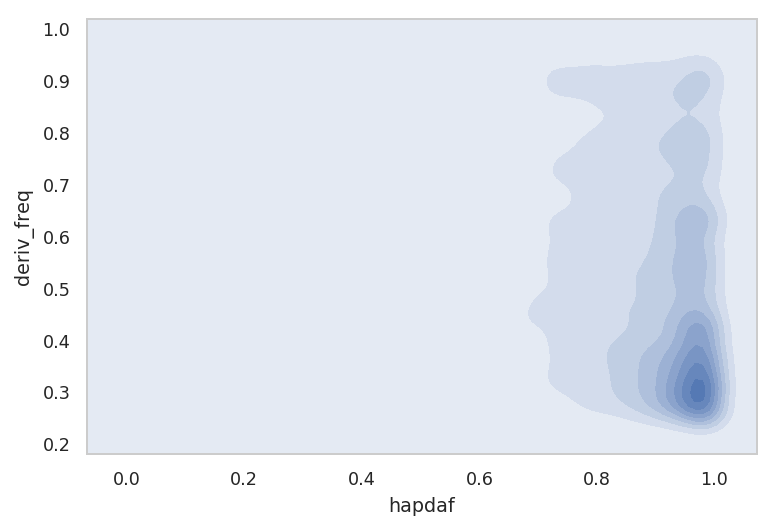

In [9]:
ax = sns.kdeplot(hapdaf_phys_chrX.hapdaf, hapdaf_phys_chrX.deriv_freq, shade=True)


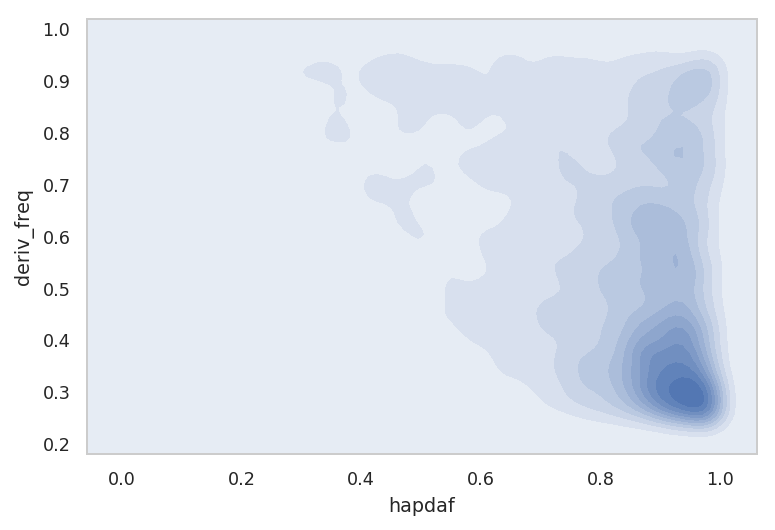

In [10]:
ax = sns.kdeplot(hapdaf_gen_chrX.hapdaf, hapdaf_gen_chrX.deriv_freq, shade=True)


In [44]:
# @window(size=100000)
# def mean_hapdaf(df, fill='hg19'):
#     df.hapdaf.mean()

# hapdaf_phys_chrX.assign(start=hapdaf_phys_chrX.phys_pos, end=hapdaf_phys_chrX.phys_pos).pipe(mean_hapdaf)

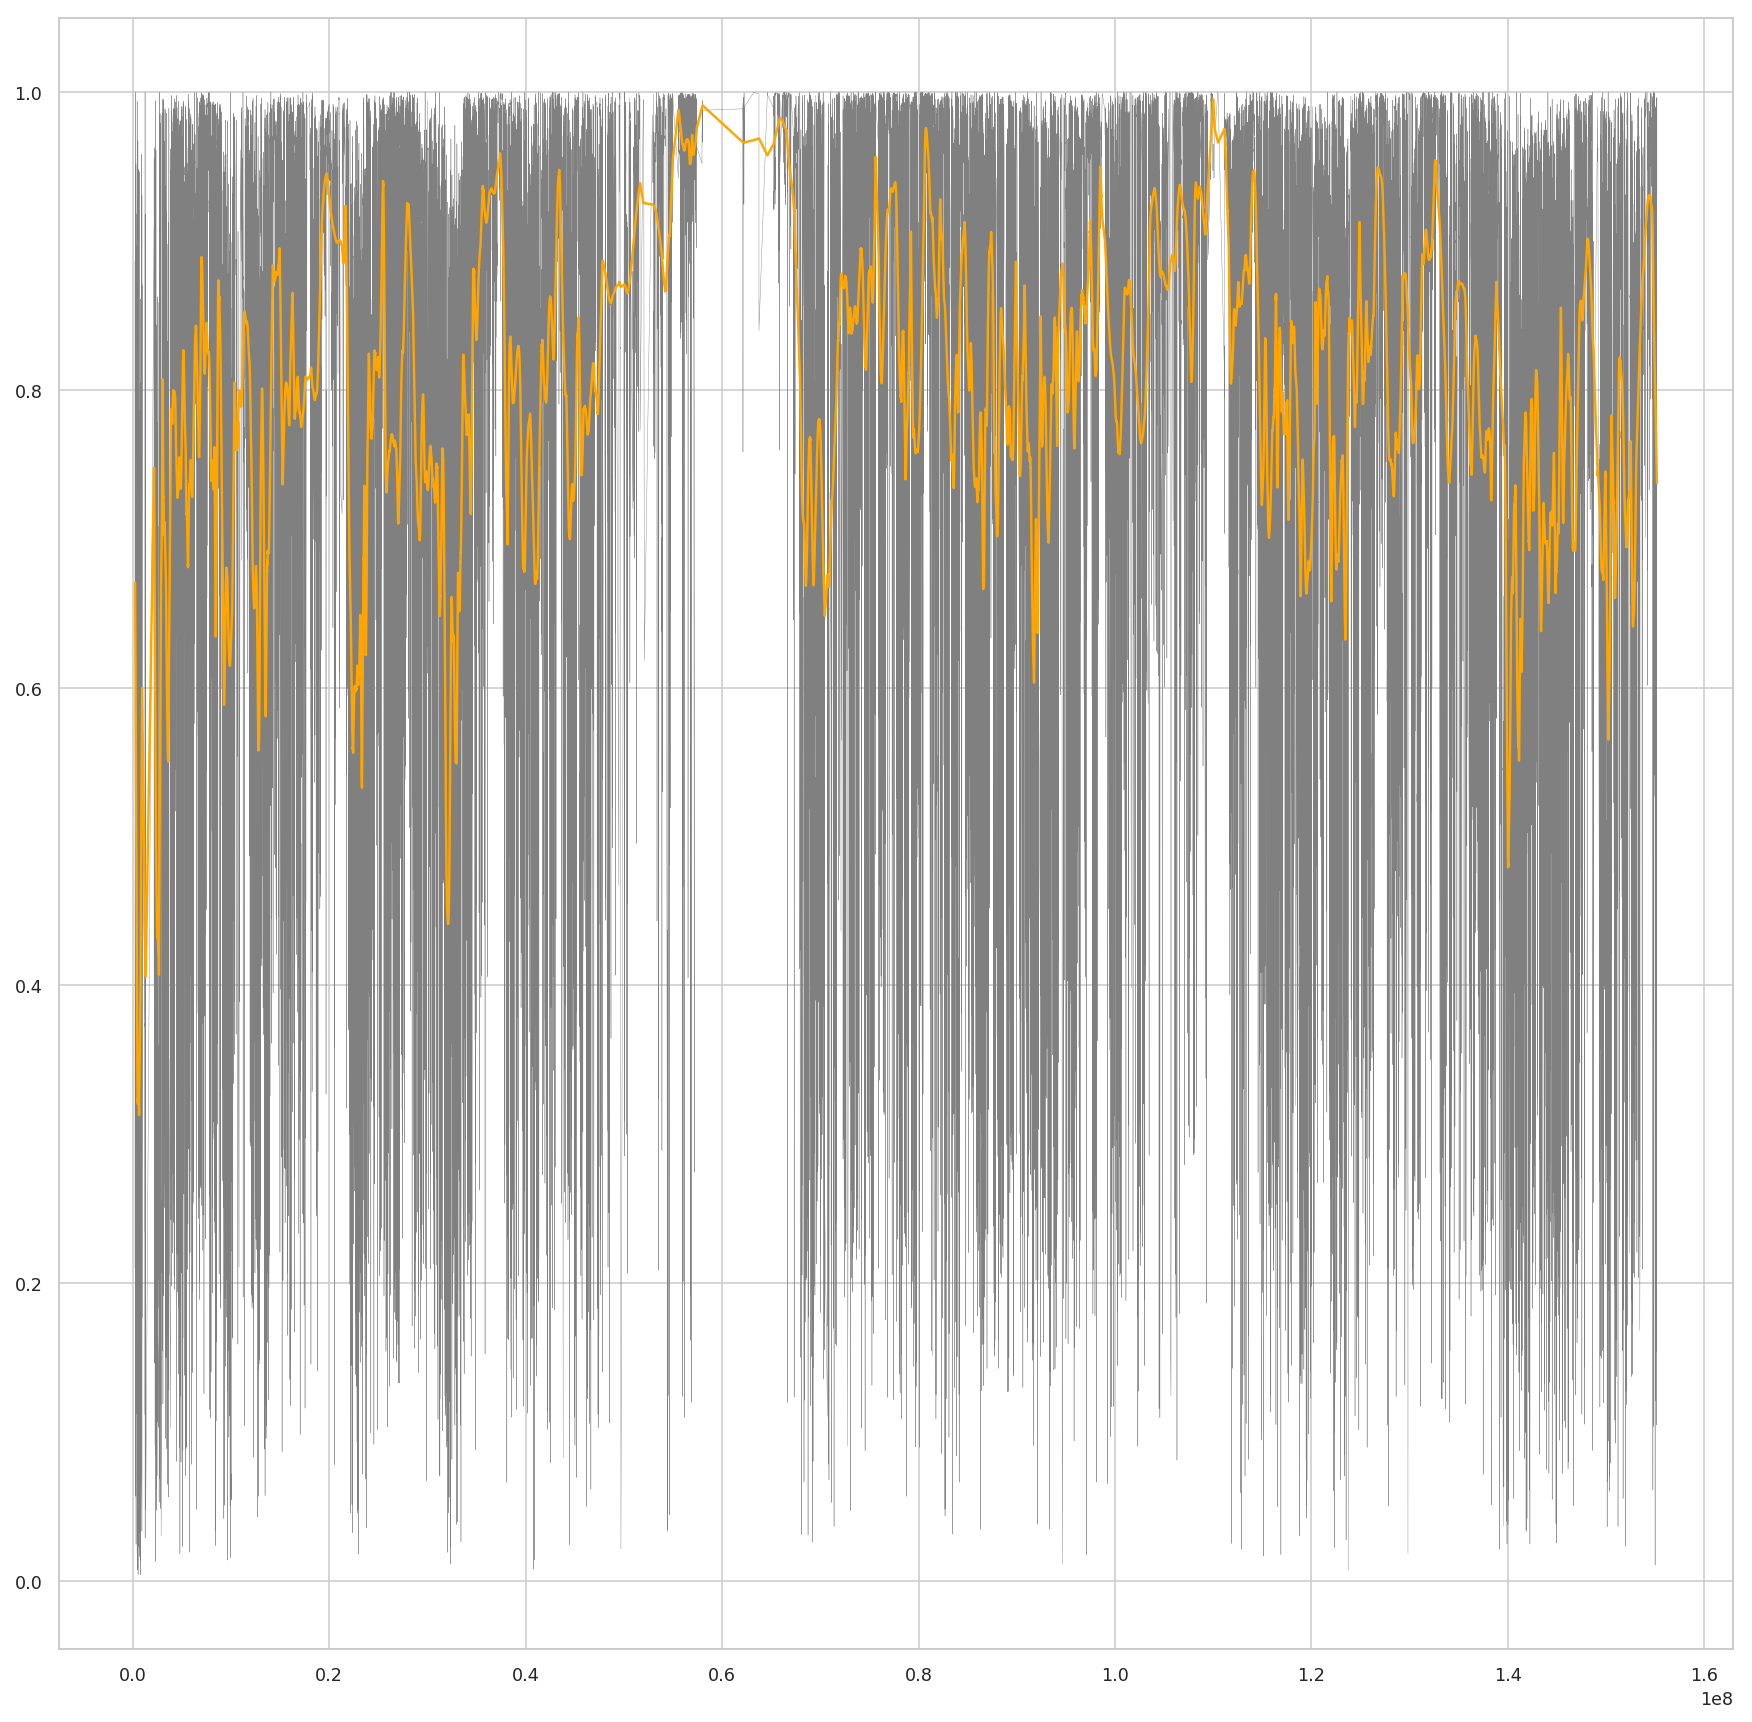

In [11]:
fig = plt.figure(figsize=(15, 15))

plt.plot(hapdaf_phys_chrX.phys_pos, hapdaf_phys_chrX.hapdaf, c='grey', linewidth=0.2)
filtered = lowess(hapdaf_phys_chrX.hapdaf, hapdaf_phys_chrX.phys_pos, 
                  is_sorted=True, frac=0.005, it=0)
plt.plot(filtered[:,0], filtered[:,1], color='orange') ;

In [ ]:
fig = plt.figure(figsize=(15, 15))
plt.plot(hapdaf_phys_chrX.phys_pos, hapdaf_phys_chrX.hapdaf)
mpld3.display(fig)

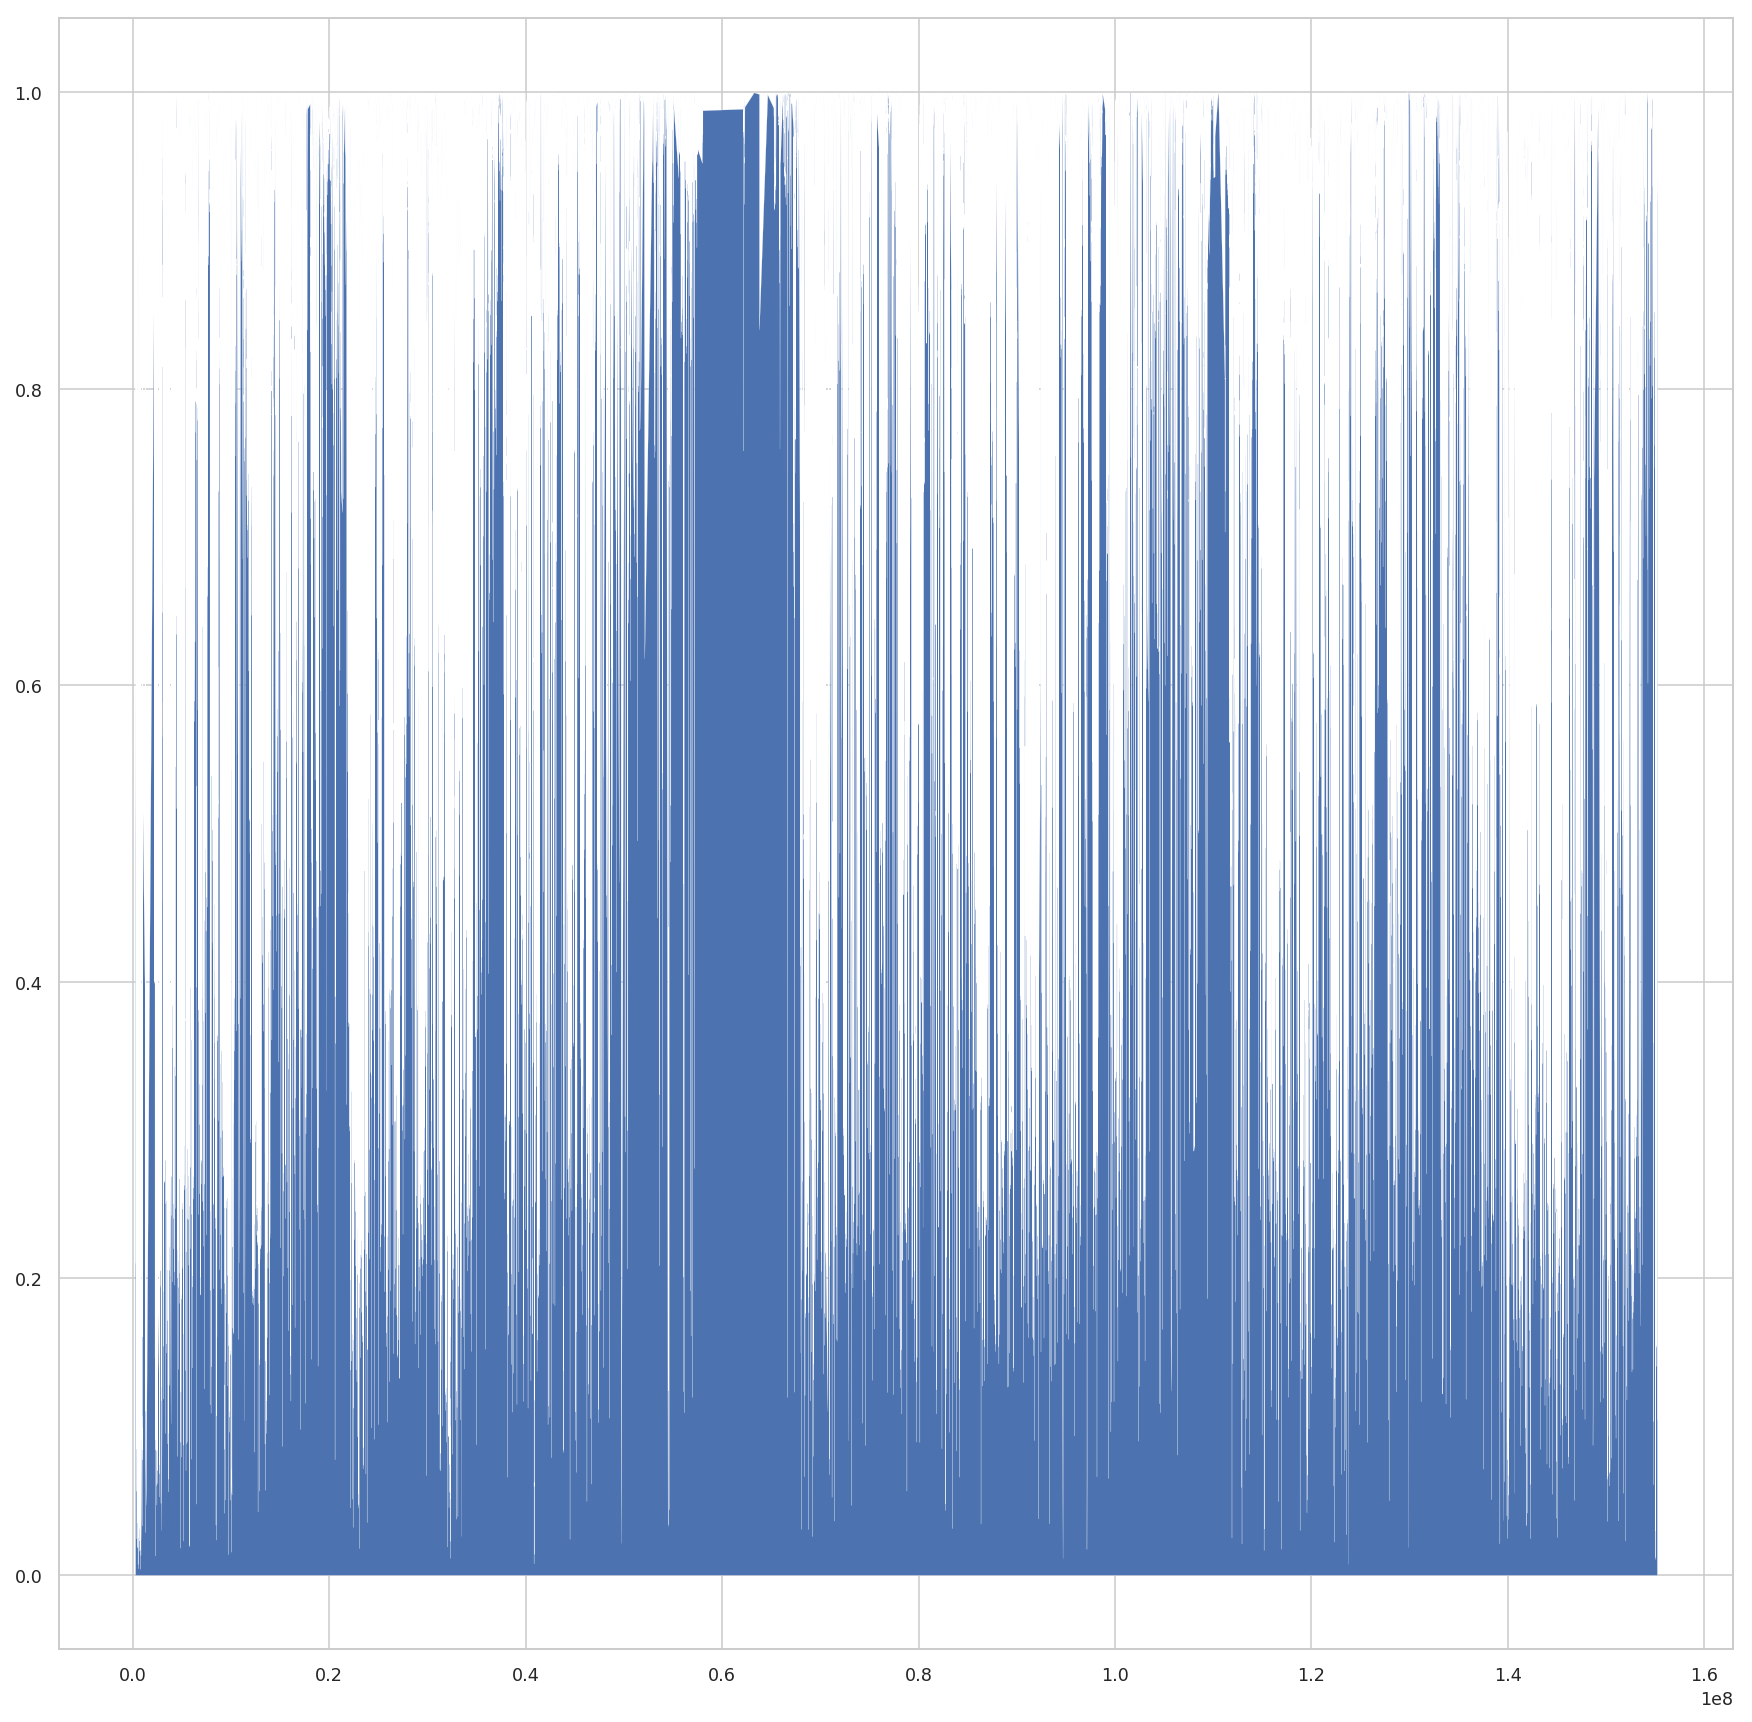

In [13]:
plt.figure(figsize=(15, 15))
plt.fill_between(hapdaf_phys_chrX.phys_pos, hapdaf_phys_chrX.hapdaf, linewidth=0.1)